<a href="https://colab.research.google.com/github/Sankoku/Human-Machine/blob/main/%22lab2_LM_Liashenko_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2. Ляшенко Роман - Blog author gender classification data set  (http://www.cs.uic.edu/~liub/FBS/blog-gender-dataset.rar)

In [2]:
!pip install nltk

In [3]:
!wget https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/comparative_sentences.zip

--2025-06-08 15:00:53--  https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/comparative_sentences.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279121 (273K) [application/zip]
Saving to: ‘comparative_sentences.zip’

comparative_sentenc 100%[===================>] 272.58K  --.-KB/s    in 0.003s  

2025-06-08 15:00:53 (77.3 MB/s) - ‘comparative_sentences.zip’ saved [279121/279121]



In [4]:
!unzip comparative_sentences.zip

Archive:  comparative_sentences.zip
   creating: comparative_sentences/
  inflating: comparative_sentences/labeledSentences.txt  
  inflating: comparative_sentences/listOfkeywords.txt  
  inflating: comparative_sentences/README.txt  


In [5]:
# Лабораторна робота №2: Наївний байєсівський класифікатор для аналізу порівняльних речень
# Датасет: Comparative Sentence Dataset

import nltk
import numpy as np
import pandas as pd
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Завантаження необхідних ресурсів NLTK
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('comparative_sentences')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

print(" Лабораторна робота №2: Наївний байєсівський класифікатор")
print(" Датасет: Comparative Sentence Dataset")
print("=" * 60)

# 1. ЗАВАНТАЖЕННЯ ТА ОБРОБКА ДАНИХ

# Список ключових слів для визначення порівняльних речень
COMPARATIVE_KEYWORDS = {
    'beat', 'inferior', 'outstrip', 'both', 'on par with', 'choice', 'choose', 'prefer',
    'recommend', 'outperform', 'superior', 'all', 'up against', 'less', 'favor', 'defeat',
    'twice', 'thrice', 'half', 'same', 'either', 'compete', 'number one', 'one of few',
    'more', 'like', 'behind', 'similar', 'identical', 'versus', 'first', 'outdistance',
    'before', 'double', 'outsell', 'nobody', 'vs', 'last', 'after', 'improve', 'equal',
    'equivalent', 'together', 'altogether', 'alternate', 'only', 'outmatch', 'ahead',
    'fraction', 'outdo', 'match', 'unmatched', 'peerless', 'differ', 'outwit', 'rival',
    'compare', 'top', 'exceed', 'lead', 'win', 'outstrip', 'none', 'near', 'unrivaled',
    'dominate', 'second', 'nonpareil', 'advantage', 'unlike', 'least', 'outclass',
    'outfox', 'outdistance', 'most', 'better', 'worse', 'best', 'worst', 'than',
    'compared', 'comparison', 'rather than', 'as good as', 'as bad as', 'faster',
    'slower', 'bigger', 'smaller', 'higher', 'lower', 'greater', 'lesser'
}

def is_comparative_sentence(sentence):
    """Визначає, чи є речення порівняльним на основі ключових слів"""
    sentence_lower = sentence.lower()

    # Перевірка на наявність ключових слів
    for keyword in COMPARATIVE_KEYWORDS:
        if keyword in sentence_lower:
            return True

    # Перевірка на граматичні форми (comparative adjectives/adverbs)
    comparative_patterns = [
        r'\b\w+er\s+than\b',  # bigger than, faster than
        r'\bmore\s+\w+\s+than\b',  # more beautiful than
        r'\bless\s+\w+\s+than\b',  # less important than
        r'\bas\s+\w+\s+as\b',  # as good as
        r'\bthe\s+\w+est\b',  # the biggest, the fastest
        r'\bmost\s+\w+\b',  # most beautiful
        r'\bleast\s+\w+\b',  # least important
    ]

    for pattern in comparative_patterns:
        if re.search(pattern, sentence_lower):
            return True

    return False

def load_comparative_data():
    """Завантаження та обробка датасету порівняльних речень"""
    from nltk.corpus import comparative_sentences

    # Отримання всіх речень
    sentences = comparative_sentences.sents()

    # Створення міток: 1 для порівняльних, 0 для непорівняльних
    labels = []
    processed_sentences = []

    for sent in sentences:
        sentence_text = ' '.join(sent)

        # Очищення від XML тегів (якщо є)
        clean_text = re.sub(r'<[^>]+>', '', sentence_text).strip()
        processed_sentences.append(clean_text)

        # Визначення, чи є речення порівняльним
        if is_comparative_sentence(clean_text):
            labels.append(1)  # порівняльне
        else:
            labels.append(0)  # непорівняльне

    return processed_sentences, labels

# Альтернативний метод завантаження з файлу (якщо потрібно)
def load_from_file(filepath):
    """Завантаження даних з файлу labeledSentences.txt"""
    sentences = []
    labels = []

    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()

        # Розділення на речення
        lines = content.split('\n')

        for line in lines:
            if line.strip():
                # Очищення від XML тегів
                clean_line = re.sub(r'<[^>]+>', '', line).strip()
                if clean_line:  # якщо після очищення щось залишилось
                    sentences.append(clean_line)

                    # Визначення мітки на основі наявності XML тегів в оригіналі
                    if any(tag in line for tag in ['<cs-1>', '<cs-2>', '<cs-3>', '<cs-4>']):
                        labels.append(1)  # порівняльне
                    else:
                        # Додаткова перевірка на ключові слова
                        if is_comparative_sentence(clean_line):
                            labels.append(1)
                        else:
                            labels.append(0)  # непорівняльне

    except FileNotFoundError:
        print(" Файл не знайдено. Використовуємо датасет з NLTK")
        return load_comparative_data()

    return sentences, labels

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package comparative_sentences to
[nltk_data]     /root/nltk_data...


 Лабораторна робота №2: Наївний байєсівський класифікатор
 Датасет: Comparative Sentence Dataset


[nltk_data]   Unzipping corpora/comparative_sentences.zip.


In [6]:
# 2. ФУНКЦІЯ ПОПЕРЕДНЬОЇ ОБРОБКИ ТЕКСТУ
def process_sentence(sentence):
    """
    Попередня обробка речення:
    - Видалення знаків пунктуації
    - Приведення до нижнього регістру
    - Токенізація
    - Видалення стоп-слів
    - Лематизація
    """
    if not sentence:
        return []

    # Видалення URL, згадок, хештегів
    sentence = re.sub(r'http\S+|www\S+|https\S+', '', sentence, flags=re.MULTILINE)
    sentence = re.sub(r'@\w+|#\w+', '', sentence)

    # Видалення знаків пунктуації та цифр
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)

    # Приведення до нижнього регістру
    sentence = sentence.lower()

    # Токенізація
    tokens = word_tokenize(sentence)

    # Видалення стоп-слів
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

    # Лематизація
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [7]:
# 3. ПОБУДОВА ЧАСТОТНОГО СЛОВНИКА
def build_freqs(sentences, labels):
    """
    Створює частотний словник у форматі:
    {(слово, мітка): частота}
    """
    freqs = defaultdict(int)

    for sentence, label in zip(sentences, labels):
        words = process_sentence(sentence)
        for word in words:
            pair = (word, float(label))
            freqs[pair] += 1

    return dict(freqs)

In [8]:
# 4. НАВЧАННЯ НАЇВНОГО БАЙЄСІВСЬКОГО КЛАСИФІКАТОРА
def train_naive_bayes(freqs, train_sentences, train_labels):
    """
    Навчання наївного байєсівського класифікатора
    Повертає logprior та loglikelihood
    """
    # Підрахунок документів кожного класу
    train_labels = np.array(train_labels)
    D_pos = np.sum(train_labels == 1)  # кількість порівняльних
    D_neg = np.sum(train_labels == 0)  # кількість непорівняльних

    print(f"  Статистика навчальної вибірки:")
    print(f"   Порівняльних речень: {D_pos}")
    print(f"   Непорівняльних речень: {D_neg}")
    print(f"   Загалом: {len(train_labels)}")

    # Обчислення апріорної ймовірності (логарифм)
    logprior = np.log(D_pos) - np.log(D_neg)

    # Створення словника логарифмічних ймовірностей
    loglikelihood = {}
    vocab = set([pair[0] for pair in freqs.keys()])

    # Підрахунок загальної кількості слів у кожному класі
    N_pos = sum([freqs.get((word, 1.0), 0) for word in vocab])
    N_neg = sum([freqs.get((word, 0.0), 0) for word in vocab])

    V = len(vocab)  # розмір словника

    for word in vocab:
        # Частота слова у порівняльних і непорівняльних реченнях
        freq_pos = freqs.get((word, 1.0), 0)
        freq_neg = freqs.get((word, 0.0), 0)

        # Згладжування Лапласа (+1)
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # Логарифмічна ймовірність
        loglikelihood[word] = np.log(p_w_pos) - np.log(p_w_neg)

    print(f" Розмір словника: {V} унікальних слів")

    return logprior, loglikelihood

In [9]:
# 5. ФУНКЦІЯ ПЕРЕДБАЧЕННЯ
def naive_bayes_predict(sentence, logprior, loglikelihood):
    """
    Передбачення класу речення (порівняльне/непорівняльне)
    Повертає логарифмічну ймовірність
    """
    words = process_sentence(sentence)

    # Початкове значення = апріорна ймовірність
    p = logprior

    # Додавання логарифмічних ймовірностей кожного слова
    for word in words:
        if word in loglikelihood:
            p += loglikelihood[word]

    return p

In [10]:
# 6. ФУНКЦІЯ ОЦІНКИ ТОЧНОСТІ
def test_naive_bayes(test_sentences, test_labels, logprior, loglikelihood):
    """
    Тестування класифікатора на тестовій вибірці
    """
    predictions = []

    for sentence in test_sentences:
        p = naive_bayes_predict(sentence, logprior, loglikelihood)
        predictions.append(1 if p > 0 else 0)

    # Обчислення точності
    accuracy = np.mean(np.array(predictions) == np.array(test_labels))

    return predictions, accuracy

In [11]:


# 7. АНАЛІЗ НАЙБІЛЬШ ЗНАЧУЩИХ СЛІВ
def get_ratio(freqs, word, label):
    """Обчислення співвідношення частот слова"""
    pos_freq = freqs.get((word, 1.0), 0) + 1
    neg_freq = freqs.get((word, 0.0), 0) + 1

    ratio = pos_freq / neg_freq
    return ratio

def analyze_words(freqs, loglikelihood, top_n=10):
    """Аналіз найбільш позитивних та негативних слів"""
    # Сортування слів за логарифмічною ймовірністю
    sorted_words = sorted(loglikelihood.items(), key=lambda x: x[1], reverse=True)

    print(f"\n🟢 Топ-{top_n} слів, що вказують на ПОРІВНЯЛЬНІ речення:")
    for word, logprob in sorted_words[:top_n]:
        ratio = get_ratio(freqs, word, 1)
        print(f"   {word:<15} | log prob: {logprob:>6.3f} | ratio: {ratio:>6.2f}")

    print(f"\n🔴 Топ-{top_n} слів, що вказують на НЕПОРІВНЯЛЬНІ речення:")
    for word, logprob in sorted_words[-top_n:]:
        ratio = get_ratio(freqs, word, 0)
        print(f"   {word:<15} | log prob: {logprob:>6.3f} | ratio: {1/ratio:>6.2f}")

Початок роботи...

1Завантаження даних...
   Завантажено 7998 речень
   Порівняльних: 4057
   Непорівняльних: 3941

2Розділення даних...
   Навчальна вибірка: 6398 речень
   Тестова вибірка: 1600 речень

3Побудова частотного словника...
   Створено 9309 унікальних пар (слово, клас)

4Навчання класифікатора...
  Статистика навчальної вибірки:
   Порівняльних речень: 3163
   Непорівняльних речень: 3235
   Загалом: 6398
 Розмір словника: 6866 унікальних слів

5Тестування класифікатора...

РЕЗУЛЬТАТИ:
   Точність на тестовій вибірці: 0.7244 (72.44%)
   Правильно класифіковано: 1159 з 1600

Детальний звіт:
               precision    recall  f1-score   support

Непорівняльні       0.72      0.61      0.66       706
  Порівняльні       0.73      0.82      0.77       894

     accuracy                           0.72      1600
    macro avg       0.72      0.71      0.71      1600
 weighted avg       0.72      0.72      0.72      1600



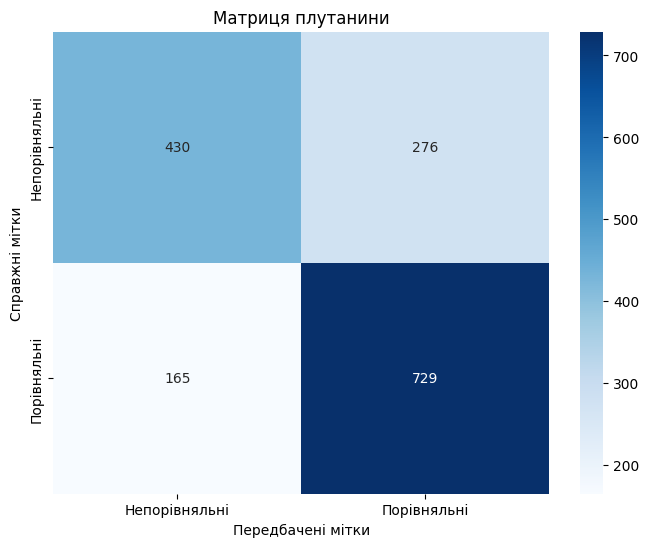


6Аналіз найбільш значущих слів...

🟢 Топ-15 слів, що вказують на ПОРІВНЯЛЬНІ речення:
   like            | log prob:  5.158 | ratio: 276.00
   best            | log prob:  4.594 | ratio: 157.00
   better          | log prob:  4.568 | ratio: 153.00
   first           | log prob:  4.443 | ratio: 135.00
   really          | log prob:  4.229 | ratio: 109.00
   small           | log prob:  3.828 | ratio:  73.00
   second          | log prob:  3.772 | ratio:  69.00
   last            | log prob:  3.757 | ratio:  68.00
   less            | log prob:  3.743 | ratio:  67.00
   window          | log prob:  3.545 | ratio:  55.00
   actually        | log prob:  3.527 | ratio:  54.00
   faster          | log prob:  3.527 | ratio:  54.00
   different       | log prob:  3.508 | ratio:  53.00
   recommend       | log prob:  3.470 | ratio:  51.00
   difference      | log prob:  3.366 | ratio:  46.00

🔴 Топ-15 слів, що вказують на НЕПОРІВНЯЛЬНІ речення:
   whatsoever      | log prob: -2.072 | ratio:   

In [12]:
# 8. ОСНОВНА ФУНКЦІЯ ВИКОНАННЯ
def main():
    print("Початок роботи...")

    # Завантаження даних
    print("\n1Завантаження даних...")
    sentences, labels = load_comparative_data()

    print(f"   Завантажено {len(sentences)} речень")
    print(f"   Порівняльних: {sum(labels)}")
    print(f"   Непорівняльних: {len(labels) - sum(labels)}")

    # Розділення на навчальну та тестову вибірки (80/20)
    print("\n2Розділення даних...")
    split_idx = int(0.8 * len(sentences))

    train_sentences = sentences[:split_idx]
    train_labels = labels[:split_idx]
    test_sentences = sentences[split_idx:]
    test_labels = labels[split_idx:]

    print(f"   Навчальна вибірка: {len(train_sentences)} речень")
    print(f"   Тестова вибірка: {len(test_sentences)} речень")

    # Побудова частотного словника
    print("\n3Побудова частотного словника...")
    freqs = build_freqs(train_sentences, train_labels)
    print(f"   Створено {len(freqs)} унікальних пар (слово, клас)")

    # Навчання класифікатора
    print("\n4Навчання класифікатора...")
    logprior, loglikelihood = train_naive_bayes(freqs, train_sentences, train_labels)

    # Тестування
    print("\n5Тестування класифікатора...")
    predictions, accuracy = test_naive_bayes(test_sentences, test_labels, logprior, loglikelihood)

    print(f"\nРЕЗУЛЬТАТИ:")
    print(f"   Точність на тестовій вибірці: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Правильно класифіковано: {int(accuracy * len(test_labels))} з {len(test_labels)}")

    # Детальний звіт
    print(f"\nДетальний звіт:")
    print(classification_report(test_labels, predictions,
                              target_names=['Непорівняльні', 'Порівняльні']))

    # Матриця плутанини
    cm = confusion_matrix(test_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Непорівняльні', 'Порівняльні'],
                yticklabels=['Непорівняльні', 'Порівняльні'])
    plt.title('Матриця плутанини')
    plt.ylabel('Справжні мітки')
    plt.xlabel('Передбачені мітки')
    plt.show()

    # Аналіз найбільш значущих слів
    print("\n6Аналіз найбільш значущих слів...")
    analyze_words(freqs, loglikelihood, top_n=15)

    # Тестування на власних прикладах
    print("\n7Тестування на власних прикладах:")
    test_sentences_custom = [
        "This camera is better than that one",
        "Apple iPhone is superior to Samsung Galaxy",
        "I love programming and data science",
        "The weather is nice today",
        "This product costs more than the previous version",
        "Both products have similar features",
        "This is the best phone on the market"
    ]

    for sentence in test_sentences_custom:
        score = naive_bayes_predict(sentence, logprior, loglikelihood)
        prediction = "Порівняльне" if score > 0 else "Непорівняльне"
        print(f"   '{sentence}'")
        print(f"   → {prediction} (score: {score:.3f})")
        print()

    return logprior, loglikelihood, freqs

# Запуск основної функції
if __name__ == "__main__":
    logprior, loglikelihood, freqs = main()